# Analysis on the QM interaction patterns of MPro structures
We have seen that the QM description offered by large-scale DFT calculations enables us to provide a different characterization of the structures.


The base fragmentation of the dimer (monomer) have been found by inspecting the MD shapshots of the protein without the presence of the ligand nor the solvent molecules.

In [149]:
5

5

In [29]:
import yaml
from matplotlib import pyplot as plt
import seaborn as sns
from futile.Utils import file_list
from pandas import DataFrame
from BigDFT import BioQM
from BigDFT.Stats import ClusterGrammer
from scipy.cluster import hierarchy as hc
from matplotlib import pyplot as plt
dimer_view=yaml.load(open('dimer_view.yaml'))

In [2]:
def run_id(name):
    nm = name if '/' not in name else name.split('/')[1]
    spl = nm.split('_')
    # print (spl)
    substrate = spl[0]
    icluster = spl.index('cluster')
    try:
        snapshot = int(spl[icluster+1])
        kind = spl[icluster+2].split('-')[0]
    except Exception:
        snapshot = int(spl[icluster+1].replace('.tar.bz2','').split('-')[0])
        kind='runs'
    return substrate,kind,snapshot
def setdefault_multiple(d,*args):
    from futile.Utils import push_path
    tmp,key = push_path(d,*args[:-1])
    tmp[key] = args[-1]
    return d

In [3]:
files = []
for key in 'inhibitors','dimer','assembly':
    files += file_list('newruns',suffix=key+'-1.1.tar.bz2',include_directory_path=True)
data = {}
for tree, file in zip(map(run_id,files),files):
    path = list(tree)
    value = {'archive':file}
    setdefault_multiple(data,*(path+[value]))

In [4]:
pops={}
for kind in data:
    print (kind)
    pops[kind] = BioQM.BioSystemPopulation.load(kind+'_populations.tar.gz')

subs02


/home/genovese/binaries/client/install/lib/python3.6/site-packages/Bio/SeqIO/PdbIO.py:292: BiopythonParserWarning: 'HEADER' line not found; can't determine PDB ID.
  BiopythonParserWarning,


0:  # weight=1.0


/home/genovese/binaries/client/install/lib/python3.6/site-packages/Bio/SeqIO/PdbIO.py:292: BiopythonParserWarning: 'HEADER' line not found; can't determine PDB ID.
  BiopythonParserWarning,


  - bond_orders
  - interactions
  - electrostatic_interactions
  - system_dfs
subs05


/home/genovese/binaries/client/install/lib/python3.6/site-packages/Bio/SeqIO/PdbIO.py:292: BiopythonParserWarning: 'HEADER' line not found; can't determine PDB ID.
  BiopythonParserWarning,


0:  # weight=1.0


/home/genovese/binaries/client/install/lib/python3.6/site-packages/Bio/SeqIO/PdbIO.py:292: BiopythonParserWarning: 'HEADER' line not found; can't determine PDB ID.
  BiopythonParserWarning,


  - bond_orders
  - interactions
  - electrostatic_interactions
  - system_dfs
subs01


/home/genovese/binaries/client/install/lib/python3.6/site-packages/Bio/SeqIO/PdbIO.py:292: BiopythonParserWarning: 'HEADER' line not found; can't determine PDB ID.
  BiopythonParserWarning,


0:  # weight=1.0


/home/genovese/binaries/client/install/lib/python3.6/site-packages/Bio/SeqIO/PdbIO.py:292: BiopythonParserWarning: 'HEADER' line not found; can't determine PDB ID.
  BiopythonParserWarning,


  - bond_orders
  - interactions
  - electrostatic_interactions
  - system_dfs
subs13


/home/genovese/binaries/client/install/lib/python3.6/site-packages/Bio/SeqIO/PdbIO.py:292: BiopythonParserWarning: 'HEADER' line not found; can't determine PDB ID.
  BiopythonParserWarning,


0:  # weight=1.0


/home/genovese/binaries/client/install/lib/python3.6/site-packages/Bio/SeqIO/PdbIO.py:292: BiopythonParserWarning: 'HEADER' line not found; can't determine PDB ID.
  BiopythonParserWarning,


  - bond_orders
  - interactions
  - electrostatic_interactions
  - system_dfs


In [5]:
def select_subregion(fragments,interactions,cutoff):
    from numpy import where,array
    return list(array(fragments)[where(abs(array(interactions)) > cutoff)[0]])
def sample_interaction_and_feedback(fragments,target,data):
    from numpy import isnan, array
    interactions = BioQM.interaction_strengths(fragments, target, data)
    environment = [f for f in fragments if f not in target]
    feedback = BioQM.interaction_strengths(fragments, environment, data)
    assert abs(sum(interactions[~isnan(interactions)])-sum(
            feedback[~isnan(feedback)])) < 1.e-4
    return array([f if frag in target else i for i, f, frag in zip(
                interactions, feedback, fragments)])

In [6]:
def determine_contact_region(sys,cutoff,criteria='bond_order'):
    substrate = sys.sequences_to_fragments[2]
    ints = sys.fragment_interaction_and_feedback(target=substrate,criteria=criteria)
    contact = select_subregion(sys.fragment_names,ints,cutoff)
    return contact
def build_dataframe_of_contact_interactions(pop,substrate,contact):
    from ase.units import Hartree, kcal, mol
    factor = Hartree / (kcal/mol)
    from BigDFT.Stats import Population,weighted_dataframe
    int_pop = Population(labels=contact)
    for df,w,l in zip(pop.datas,pop.weights,pop.sample_labels):
        fragments = list(df.columns)
        interactions = factor*BioQM.interaction_strengths(fragments, substrate, df)
        dt = {f:[interactions[fragments.index(f)]] for f in contact}
        int_pop.append(data=dt,weight=w,label=l)
    return weighted_dataframe(int_pop.datas,int_pop.weights)

In [7]:
def determine_sort_order(sys,ct):
    st={}
    for fr in ct:
        ipos = sys.fragment_ids[fr]
        st[ipos] = fr
    return [st[f] for f in sorted(st)]

In [8]:
def contact_df_of_substrate(pops,contact,criteria='interactions'):
    substrate= pops.sequences_to_fragments[2]
    pop=pops.populations[criteria]
    df=build_dataframe_of_contact_interactions(pop,substrate,[c for c in contact if c not in substrate]) 
    sort=determine_sort_order(pops,contact)
    form = ['letter','num'] if criteria=='interactions' else ['ch','-','letter','num']
    return df[sort].rename(columns=pops.labeldict(fmt=form))

In [9]:
def overall_contact_region(pops,cutoff,criteria='bond_order'):
    all_contact_regions=[]
    for subs, sys in pops.items():
        contact=determine_contact_region(sys,cutoff,criteria)
        all_contact_regions += [c for c in contact if c not in all_contact_regions and 'C-' not in c]
    return all_contact_regions
def rename_fragment(res):
    from BigDFT.BioQM import rename_residue
    renamed = rename_residue(res)
    ch,idlett = renamed.split('-')
    ids,lett = idlett.split(':')
    shift={'A': 0, 'B': 0, 'C': -7}
    if ch == 'C':
        n=int(ids)+shift.get(ch,0)
        if n>=0: n+=1
        return '\n'.join([lett,'P'+str(abs(n))+ ("'" if n > 0 else '')])
    else:
        return '\n'.join([lett,str(int(ids)+shift.get(ch,0))])
def interaction_graph(sys,cutoff,ax=None):
    subs_frag = sys.sequences_to_fragments[2]
    remap=list(map(rename_fragment,sys.fragment_names))
    interactions = sys.fragment_interaction_and_feedback(subs_frag,criteria='hamiltonian')
    ax=sys.display_graph(restrict_to=subs_frag,bo_cutoff=cutoff,fragment_labels=remap,
                      field_vals=interactions,ax=ax)
    return ax

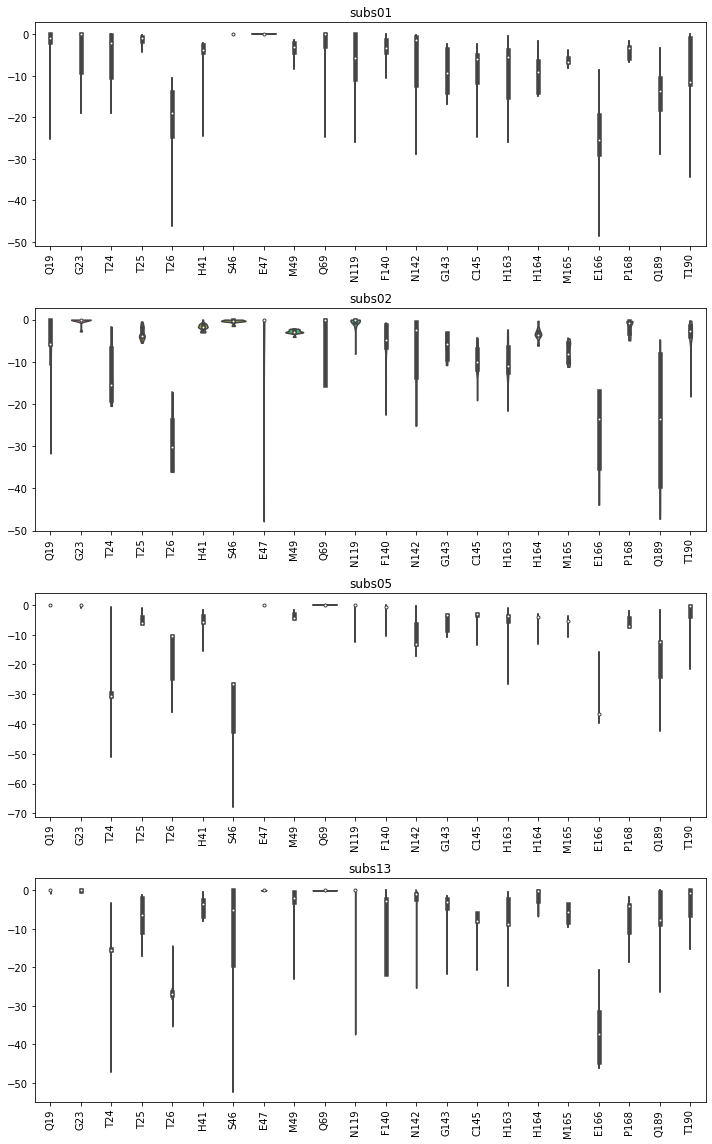

In [10]:
ct=overall_contact_region(pops,0.005)
alldf={subs: contact_df_of_substrate(pops[subs],ct) for subs in pops}
fig, axs = plt.subplots(4,1,figsize=(10,16))
for subs,ax in zip(sorted(alldf),axs):
    #ax=alldf[subs].boxplot(ax=ax)
    ax=sns.violinplot(data=alldf[subs],ax=ax,cut=0)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    ax.set_title(subs)
fig.tight_layout()

Text(0.5, 1.0, 'subs01')

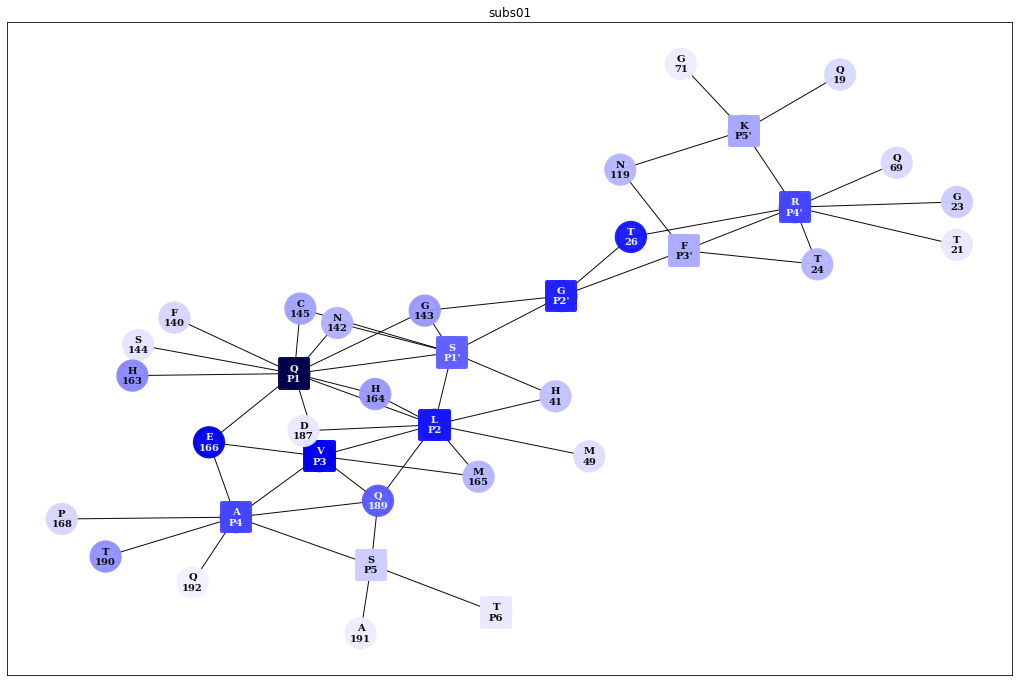

In [11]:
subs='subs01'
ax=interaction_graph(pops[subs],0.005)
ax.set_title(subs)

Text(0.5, 1.0, 'subs02')

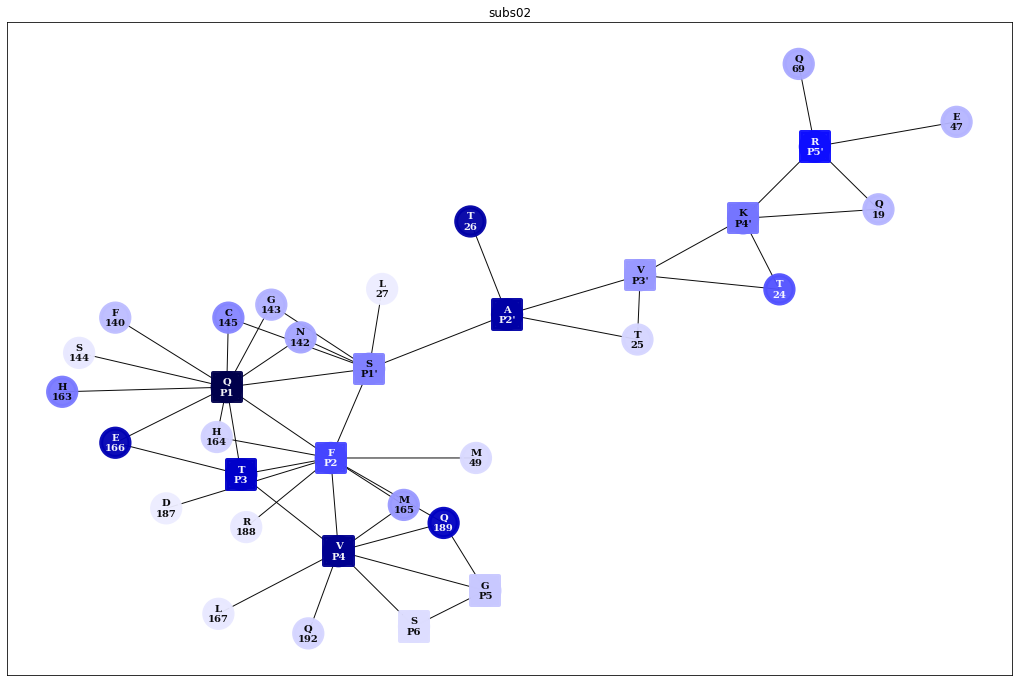

In [12]:
subs='subs02'
ax=interaction_graph(pops[subs],0.005)
ax.set_title(subs)

Text(0.5, 1.0, 'subs05')

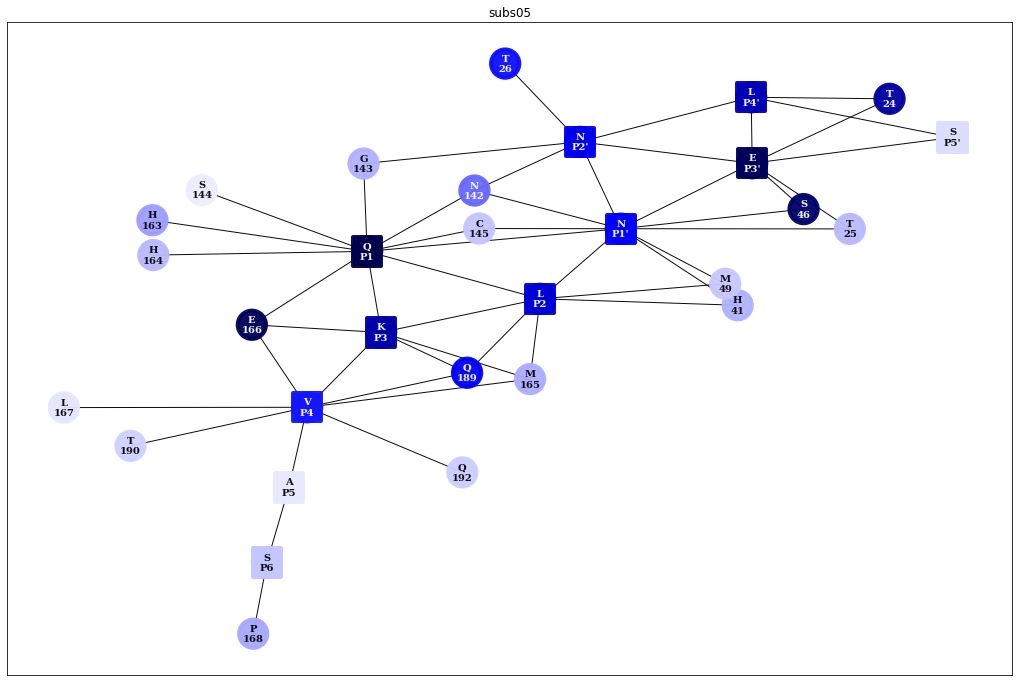

In [13]:
subs='subs05'
ax=interaction_graph(pops[subs],0.005)
ax.set_title(subs)

Text(0.5, 1.0, 'subs13')

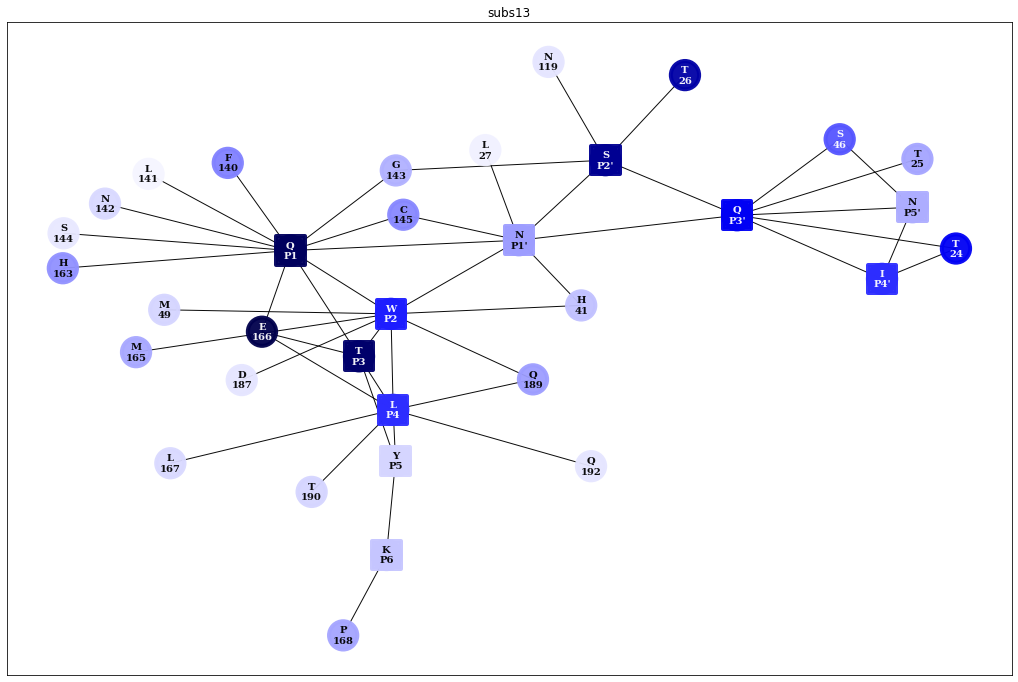

In [14]:
subs='subs13'
ax=interaction_graph(pops[subs],0.005)
ax.set_title(subs)

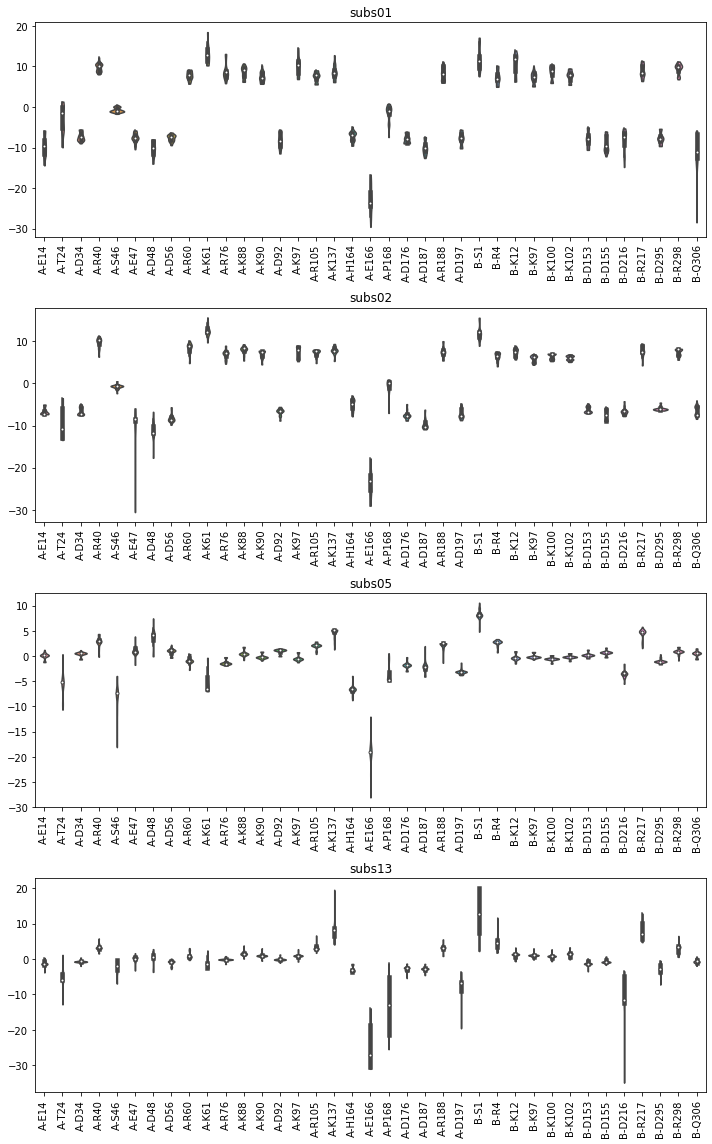

In [15]:
from ase.units import Hartree, kcal, mol
factor = Hartree / (kcal/mol)
ct=overall_contact_region(pops,7.0/factor,'electrostatic')
alldf={subs: contact_df_of_substrate(pops[subs],ct,'electrostatic_interactions') for subs in pops}
fig, axs = plt.subplots(4,1,figsize=(10,16))
for subs,ax in zip(sorted(alldf),axs):
    #ax=alldf[subs].boxplot(ax=ax)
    ax=sns.violinplot(data=alldf[subs],ax=ax,cut=0)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    ax.set_title(subs)
fig.tight_layout()

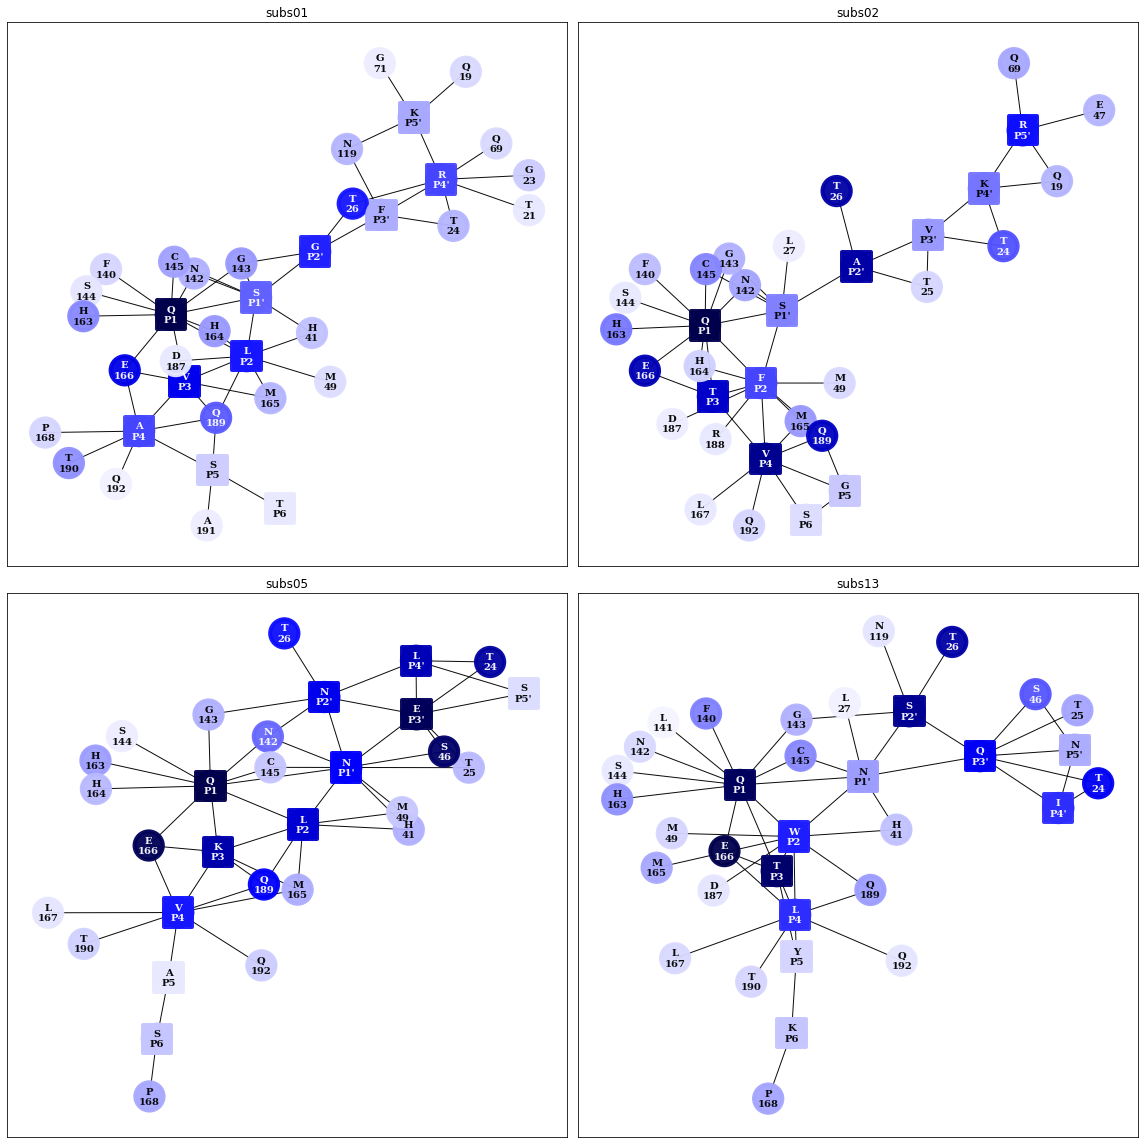

In [17]:
fig, axs = plt.subplots(2,2,figsize=(16,16))
for subs,ax in zip(sorted(pops),axs.flatten()):
    ax=interaction_graph(pops[subs],0.005,ax)
    ax.set_title(subs)
fig.tight_layout()

We also load the data of the XChem fragment analysis

In [18]:
XChem = BioQM.BioSystemPopulation.load('../../../gitprojects/diamond-refresh/diamond-moonshot.tar.gz',options=dict(sequence_from_fragments=True,disable_warnings=True))

/home/genovese/binaries/client/install/lib/python3.6/site-packages/BigDFT/BioQM.py:607: UserWarning: Some atoms were not matchedUnable to match atom{'sym': 'H', 'r': [6.351, -3.914, 22.4], 'name': 'H', 'units': 'angstroem'}
  warn('Some atoms were not matched' + str(e))


0:  # weight=1.0


/home/genovese/binaries/client/install/lib/python3.6/site-packages/BigDFT/BioQM.py:607: UserWarning: Some atoms were not matchedUnable to match atom{'sym': 'H', 'r': [6.351, -3.914, 22.4], 'name': 'H', 'units': 'angstroem'}
  warn('Some atoms were not matched' + str(e))


  - bond_orders
  - interactions
  - electrostatic_interactions
  - system_dfs


In [19]:
def load_from_serialized_dict(atdict, preserve_keys=[]):
    from BigDFT.Atoms import Atom
    raw_keys = ['qel_0'] + preserve_keys
    xyz = ['x', 'y', 'z']
    newdict = {}
    reworked_keys = set()
    for key, val in atdict.items():
        if '_' not in key or key in raw_keys:
            newdict[key] = val
            continue
        if 'coord' in key:
            ipos = xyz.index(key.split('_')[0])
            newkey = 'r'
        else:
            newkey, ipos = key.split('_')
        reworked_keys.add(newkey)
        newdict.setdefault(newkey, {}).setdefault(int(ipos), val)
    for key in reworked_keys:
        newval = [newdict[key][ipos] for ipos in sorted(list(newdict[key].keys()))]
        newdict[key] = newval
    return Atom(newdict)
        
def system_from_df(df):
    from BigDFT.Systems import System
    from BigDFT.Fragments import Fragment
    
    dft = df.transpose()
    sys=System()
    for at in dft:
        atdict = dft[at].to_dict()
        frag = atdict.pop('frag')
        at = load_from_serialized_dict(atdict)
        sys.setdefault(frag,Fragment()).append(at)
    return sys

Reconstitute the population data as they are supposed to be defined

In [20]:
def new_populations(populations):
    from BigDFT.Stats import Population
    oldpop = populations['system_dfs']
    pop_sys = Population(labels=oldpop.feature_labels)
    pop_el = Population(labels=oldpop.feature_labels)
    for df,w,l in zip(oldpop.datas,oldpop.weights,oldpop.sample_labels):
        sys=system_from_df(df)
        pop_sys.append(data=sys.df,weight=w,label=l)
        pop_el.append(data=sys.electrostatic_interactions,weight=w,label=l)
    return pop_sys,pop_el

In [21]:
pop_sys, pop_el = new_populations(XChem.populations)

In [22]:
new_electrostatic = {}
for lb,df,el in zip(pop_sys.sample_labels,pop_sys.datas,pop_el.datas):
    print (lb)
    sys=system_from_df(df)
    target = [f for f in sys if 'LIG' in f]
    fragments=list(sys)
    elec = sample_interaction_and_feedback(fragments,target,el)
    new_electrostatic[lb] = {f: e for e,f in zip(elec,fragments)}

x1392
x1412
x0705
x1418
x0708
x0426
x0425
x0387
x1093
x0305
x1308
x1012
x1493
x0540
x0946
x1119
x1402
x1351
x0736
x0734
x0731
x0434
x1086
x1101-1
x1101-0
x1002
x0336
x0771
x1311
x0830
x0831
x1249
x0689
x0195
x0194
x1425
x1132
x1336
x0759
x0755
x0752
x1235
x0350
x1237
x0354
x0692
x0991
x0995
x0669
x1458
x0749
x1348
x1187
x0464
x1226
x1334
x0678
x0104
x0376
x0107
x0786
x1358
x0770
x0774
x0478
x0874
x0390
x0978
x0769
x1077
x1478
x0177
x0072
x0981
x1163
x1385
x1384
x1386
x1380
x1382
x0887
x0499
x0967
x0161
x0398
x0165
x0395
x0397
x1374
x1375
x0691
x0820


In [23]:
new_contact = {}
for lb,df,el in zip(pop_sys.sample_labels,pop_sys.datas,XChem.populations['interactions'].datas):
    print (lb)
    sys=system_from_df(df)
    target = [f for f in sys if 'LIG' in f]
    fragments=list(sys)
    contact= sample_interaction_and_feedback(fragments,target,el)
    new_contact[lb] = {f: e for e,f in zip(contact,fragments)}

x1392
x1412
x0705
x1418
x0708
x0426
x0425
x0387
x1093
x0305
x1308
x1012
x1493
x0540
x0946
x1119
x1402
x1351
x0736
x0734
x0731
x0434
x1086
x1101-1
x1101-0
x1002
x0336
x0771
x1311
x0830
x0831
x1249
x0689
x0195
x0194
x1425
x1132
x1336
x0759
x0755
x0752
x1235
x0350
x1237
x0354
x0692
x0991
x0995
x0669
x1458
x0749
x1348
x1187
x0464
x1226
x1334
x0678
x0104
x0376
x0107
x0786
x1358
x0770
x0774
x0478
x0874
x0390
x0978
x0769
x1077
x1478
x0177
x0072
x0981
x1163
x1385
x1384
x1386
x1380
x1382
x0887
x0499
x0967
x0161
x0398
x0165
x0395
x0397
x1374
x1375
x0691
x0820


In [24]:
def represent_interaction_and_feedback(sys,criteria):
    substrate = sys.sequences_to_fragments[2]
    data = sys.fragment_interaction_and_feedback(target=substrate,criteria=criteria)
    return {f: e for e,f in zip(data,sys.fragment_names)}
for name,sys in pops.items():
    new_contact[name]=represent_interaction_and_feedback(sys,'hamiltonian')
    new_electrostatic[name]=represent_interaction_and_feedback(sys,'electrostatic')


In [45]:
subs_contact={}
subs_electrostatic={}
for name,sys in pops.items():
    subs_contact[name]=represent_interaction_and_feedback(sys,'hamiltonian')
    subs_electrostatic[name]=represent_interaction_and_feedback(sys,'electrostatic')


In [47]:
from BigDFT.PostProcessing import systems_heatmap

In [ ]:
ct_df.rename

In [60]:
ct_df = factor*DataFrame(subs_contact)
ct=overall_contact_region(pops,0.005)
sort=determine_sort_order(sys,ct)
lb = sys.labeldict(fmt=['letter','num'])
relct = [lb[c] for c in sort]

In [61]:
ct_df=ct_df.transpose()[sort].rename(columns=lb).transpose()

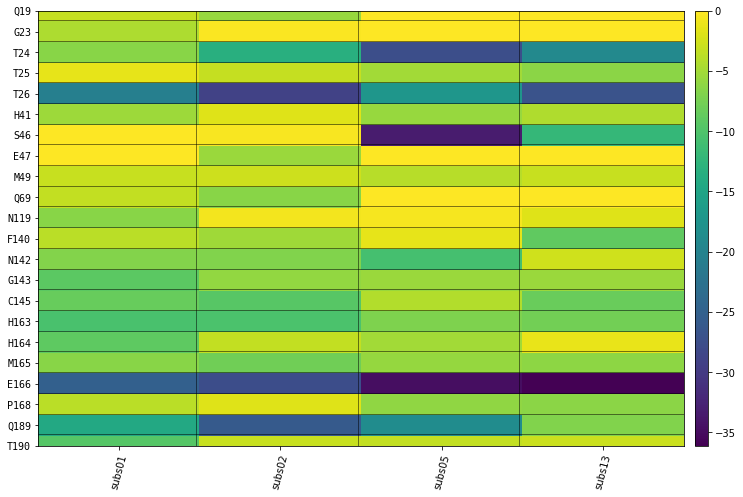

In [63]:
im=systems_heatmap(ct_df,restrict_to=[relct],columns=sorted(ct_df.columns))

In [69]:
el_df = factor*DataFrame(subs_electrostatic)
ct=overall_contact_region(pops,7.0/factor,'electrostatic')
sort=determine_sort_order(pops['subs01'],ct)
lb = pops['subs01'].labeldict(fmt=['ch','-','letter','num'])
relct = [lb[c] for c in sort]

In [71]:
el_df=el_df.transpose()[sort].rename(columns=lb).transpose()

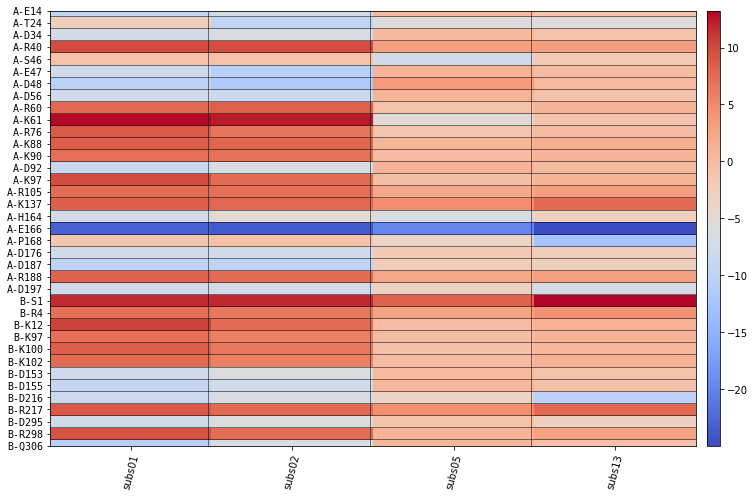

In [76]:
im=systems_heatmap(el_df,restrict_to=[relct],columns=sorted(el_df.columns),cmap='coolwarm')

In [78]:
el_df = DataFrame(new_electrostatic)
ct_df = DataFrame(new_contact)

In [97]:
cg=ClusterGrammer(el_df.dropna().rename(index=BioQM.rename_residue))

In [98]:
cg.show()

/usr/local/lib/python3.6/dist-packages/clustergrammer_widget/clustergrammer/run_filter.py:74: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  df = df.ix[keep_rows]
/usr/local/lib/python3.6/dist-packages/clustergrammer_widget/clustergrammer/make_views.py:28: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  tmp_df['mat'] = tmp_df['mat'].ix[keep_rows]


clustergrammer_widget(network='{"row_nodes": [{"name": "A-116:A", "ini": 301, "clust": 32, "rank": 63, "rankva…

In [99]:
#link=cg.publish('electrostatic_interactions_subs_XChem')

In [102]:
cg.publish_link()

'http://maayanlab.cloud/clustergrammer/viz/603f624cd0867e01721c47e5/electrostatic_interactions_subs_XChem.tsv'

In [136]:
cluster5='x0107, x0434, x0540, x0678, x0967'.split(', ')
contact_clusters = 'x0426, x1093, x0540, x0946, x0434, x0195, x0995, x0678, x0104, x0107, x0874, x1077, x0967, x0161, x0397, subs02, subs05, subs01, subs13'.split(', ')
el_clusters = 'x0387, x0752, x0354'.split(', ')

In [129]:
contact_clusters = [c for c in contact_clusters if c not in cluster5]

In [117]:
ylabs=ax.get_yticklabels()

In [146]:
def color_labels(ax,cluster5,contact_clusters,el_clusters):
    ylabs=ax.get_yticklabels()
    for lab in ylabs:
        if lab.get_text() in cluster5:
            lab.set_color('blue')
        elif lab.get_text() in contact_clusters:
            lab.set_color('red')
        elif lab.get_text() in el_clusters:
            lab.set_color('purple')



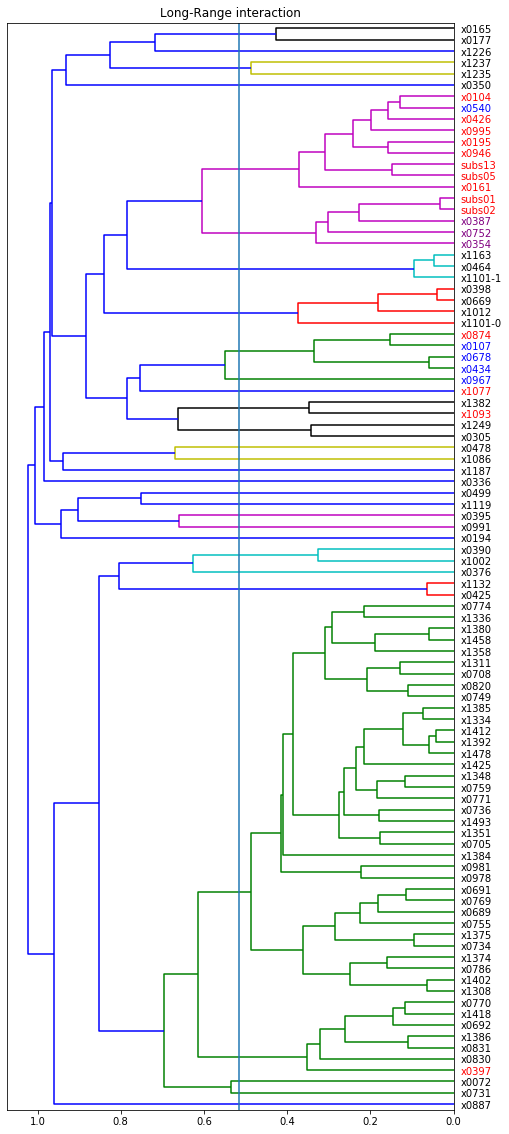

In [147]:
dataframe=(el_df).dropna()
z = hc.linkage(dataframe.values.T, method='average', metric='correlation')
fig,ax = plt.subplots(figsize=(8,20))
dendrogram = hc.dendrogram(z, labels=dataframe.columns, ax= ax, orientation='left')
ax.axvline(0.515)
color_labels(ax,cluster5,contact_clusters,el_clusters)
ax.set_title('Long-Range interaction')
_=ax.set_yticklabels(ax.get_yticklabels(),fontsize=10)

In [103]:
ct_cg=ClusterGrammer(ct_df.dropna().rename(index=BioQM.rename_residue))

In [104]:
ct_cg.show()

/usr/local/lib/python3.6/dist-packages/clustergrammer_widget/clustergrammer/run_filter.py:74: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  df = df.ix[keep_rows]
/usr/local/lib/python3.6/dist-packages/clustergrammer_widget/clustergrammer/make_views.py:28: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  tmp_df['mat'] = tmp_df['mat'].ix[keep_rows]


clustergrammer_widget(network='{"row_nodes": [{"name": "A-003:F", "ini": 144, "clust": 129, "rank": 134, "rank…

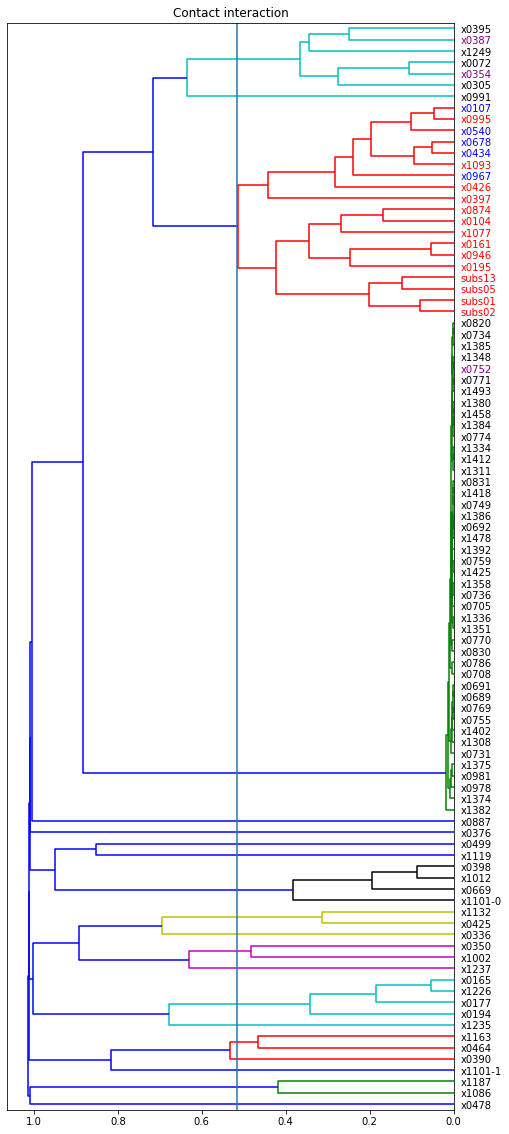

In [148]:
dataframe=(ct_df).dropna()
z = hc.linkage(dataframe.values.T, method='average', metric='correlation')
fig,ax = plt.subplots(figsize=(8,20))
dendrogram = hc.dendrogram(z, labels=dataframe.columns, ax= ax, orientation='left')
ax.axvline(0.515)
color_labels(ax,cluster5,contact_clusters,el_clusters)
ax.set_title('Contact interaction')
_=ax.set_yticklabels(ax.get_yticklabels(),fontsize=10)


In [108]:
#ct_cg.publish('contact_interactions_subs_XChem')

In [109]:
ct_cg.publish_link()

'http://maayanlab.cloud/clustergrammer/viz/603f6484d0867e01721c4820/contact_interactions_subs_XChem.tsv'